In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
### PREPROCESSING
#-----

def preprocess(df) -> pd.DataFrame:

    df = df.drop(['Name', 'Ticket'], axis=1)

    # Many in lowest class didn't travel in cabins, so I give them the lowest floor
    df['Cabin'] = df['Cabin'].fillna('G')

    cabin_letters = Counter(col[0] for col in df['Cabin']).keys()

    # print(cabin_letters) ### We see that the floors range from A - G, then T

    # Assign numbers to cabin letters from 6-0 for A-G, and 13 for special cabin T
    cabin_dict = {i:abs(ord(i)-71) for i in cabin_letters}

    # Replace cabin number with deck floor
    df['Cabin'] = [cabin_dict[col[0]] for col in df['Cabin'] if col[0] ]

    # Replace missing values for age with the average age for that sex
    avg_m = np.nanmean(df['Age'][df['Sex'] == 'male'])
    avg_f = np.nanmean(df['Age'][df['Sex'] == 'female'])
    avg_dict = {'male': avg_m, 'female': avg_f}
    df['Age'] = [avg_dict[df['Sex'][i]] if np.isnan(j) else j for i, j in enumerate(df['Age'])]

    # Quantify age + embarkation point
    df['Sex'] = [1 if i == 'male' else 0 for i in df['Sex']]

    em_dict = {'S': 2, 'C': 1, 'Q': 0}
    df['Embarked'] = [2 if str(i) not in 'S-C-Q' else em_dict[i] for i in df['Embarked']]

    if df['Fare'].isna().sum() > 0:
        avg_fare = np.nanmean(df['Fare'])
        df['Fare'] = [avg_fare if np.isnan(i) else i for i in df['Fare']]

    print(df.isna().sum()) # No nan values left for either

    return df.astype('float32').values

In [3]:
df_ts = pd.read_csv('/kaggle/input/titanic/test.csv')
df_tr = pd.read_csv('/kaggle/input/titanic/train.csv')

print('\n NaNs in Train:')
proc_tr = preprocess(df_tr)

print('\n NaNs in Test:')
proc_ts = preprocess(df_ts)

data_t = torch.tensor(proc_tr)
pred_t = torch.tensor(proc_ts)

splits = KFold(n_splits=3, shuffle=True)


 NaNs in Train:
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

 NaNs in Test:
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [4]:
# Important lines are commented for clarity

class NeuralNetwork(nn.Module):
    def __init__(self, init_size, p_dropout=0.1, layer_size=50):
        super().__init__()
        # Define the neural network architecture using Sequential
        self.stack = nn.Sequential(
            nn.Linear(init_size, layer_size),
            nn.Dropout1d(p=p_dropout),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.stack(x)

def cross_val(splits, data_t, batch_size=10, n_epochs=50, p_dropout=0.1, layer_size=50):
    avg_train, avg_test = 0, 0
    for _, (train_idx, test_idx) in enumerate(splits.split(np.arange(len(data_t)))):

        # Extract training and testing datasets
        data_tr = data_t[train_idx]
        data_ts = data_t[test_idx]

        # Extract features (X) and labels (y) for training
        X_tr = data_tr[:, 2:].float()
        y_tr = data_tr[:, 1].expand(1, -1).T
        len_tr = len(X_tr)

        # Extract features (X) and labels (y) for testing
        X_ts = data_ts[:, 2:].float()
        y_ts = data_ts[:, 1].expand(1, -1).T
        len_ts = len(X_ts)
        
        # Initialize the neural network model, optimizer, and loss function
        model = NeuralNetwork(len(X_tr[0]), p_dropout, layer_size)
        optimizer = optim.Adam(model.parameters(), lr=0.003)
        loss_fn = nn.BCELoss()

        losses = np.zeros(n_epochs)
        model.train()
        # Training loop
        for epoch in range(n_epochs):
            for i in range(0, len_tr, batch_size):
                Xbatch = X_tr[i:i + batch_size]
                y_pred = model(Xbatch)
                ybatch = y_tr[i:i + batch_size]
                loss = loss_fn(y_pred, ybatch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses[epoch] = loss

        ### Document losses
        # plt.scatter(np.arange(n_epochs), losses)
        # plt.show()
        
        # Calculate and accumulate training accuracy
        avg_train += (sum([round(model(X_tr)[i].item()) == y_tr[i] for i in range(len_tr)]).item() / len_tr) * 100

        model.eval()
        # Evaluate the model on the test set
        output = model(X_ts)
        # Calculate and accumulate test accuracy
        avg_test += (sum([round(output[i].item()) == y_ts[i] for i in range(len_ts)]).item() / len_ts) * 100
    return avg_train / 3, avg_test / 3, model

def save_if_best(max_acc, avg_test, model):
    # Save the model if the current test accuracy is higher than the previous best
    if avg_test > max_acc:
        torch.save(model.state_dict(), 'model.pt')
        max_acc = avg_test
    return max_acc

max_acc = 0  # Initialize max accuracy
_, avg_test, model = cross_val(splits, data_t)
max_acc = save_if_best(max_acc, avg_test, model)
print(max_acc)

79.01234567901236


batch_size


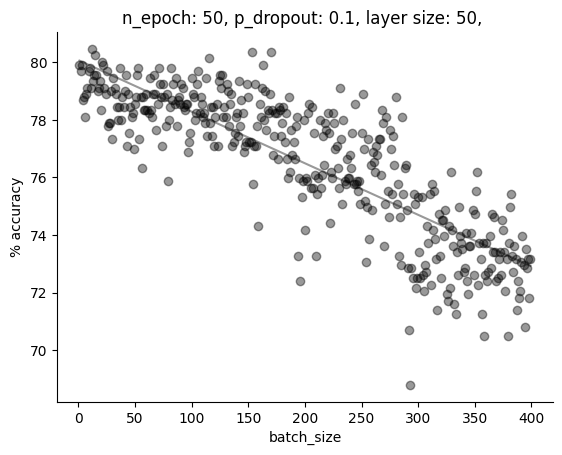

n_epoch


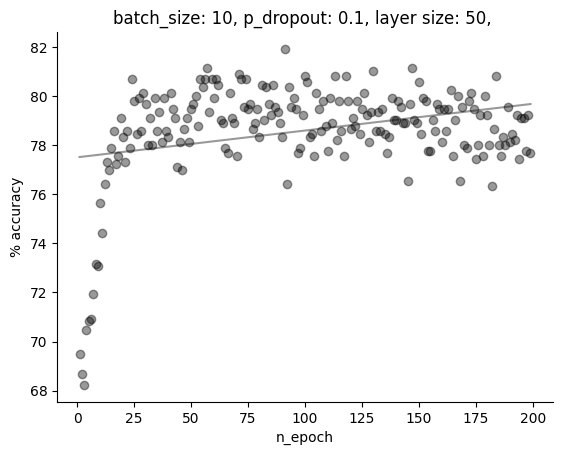

p_dropout


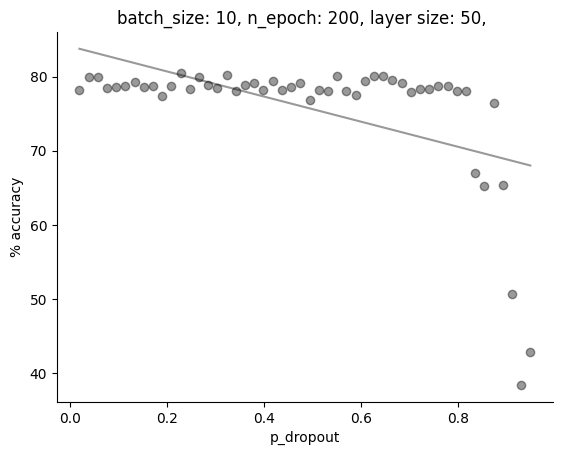

layer size


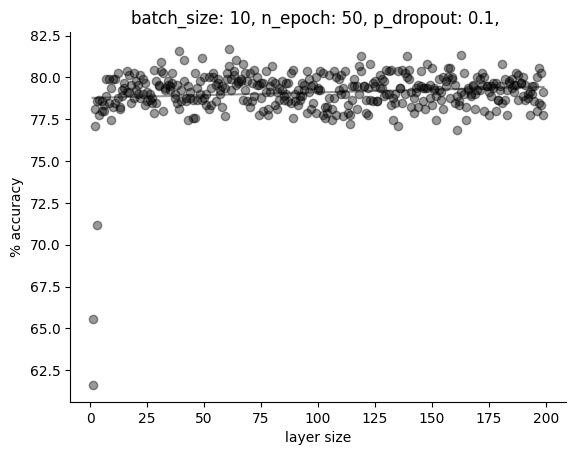

81.9304152637486

In [5]:
# Function to calculate the best-fit line parameters
def best_fit(iterable, history):
    xbar = sum(iterable)/len(iterable)
    ybar = sum(history)/len(history)
    n = len(iterable) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(iterable, history)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in iterable]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b

# Function to test different values for a specific hyperparameter
# param_no ... batch_size: 0, n_epoch: 1, p_dropout: 2, layer size: 3
def test_for_param(iterable, param_no, default_params, max_acc):
    param_names = ['batch_size', 'n_epoch', 'p_dropout', 'layer size']
    print(param_names[param_no])
    
    params = default_params.copy()
    n_iter = iterable.size
    history = np.zeros(n_iter)
    
    # Iterate through the values of the hyperparameter and record accuracy
    for i, j in enumerate(iterable):
        params[param_no] = j
        _, avg_test, model = cross_val(splits, data_t, *params)
        history[i] = avg_test
        max_acc = save_if_best(max_acc, avg_test, model)
    
    # Calculate and plot the best-fit line
    a, b = best_fit(iterable, history)
    yfit = [a + b * xi for xi in iterable]
    title = ''.join([f'{param_names[i]}: {str(j)}, ' if i != param_no else '' for i, j in enumerate(default_params)])
    ax = plt.subplot(111)
    plt.plot(iterable, yfit, 'k', alpha=0.4)
    plt.scatter(iterable, history, c='k', alpha=0.4)
    plt.title(title)
    plt.ylabel('% accuracy')
    plt.xlabel(param_names[param_no])
    ax.spines[['right', 'top']].set_visible(False)
    plt.show()
    
    return max_acc, history

# Default hyperparameter values
default_params = [10, 50, 0.1, 50]

# Test different values for each hyperparameter and update max accuracy
max_acc, _ = test_for_param(np.repeat(np.arange(1, 400), repeats=1), 0, default_params, max_acc)
max_acc, _ = test_for_param(np.repeat(np.arange(1, 200), repeats=1), 1, default_params, max_acc)
max_acc, _ = test_for_param(np.linspace(0.02, 0.95), 2, [10, 200, 0.1, 50], max_acc)
max_acc, _ = test_for_param(np.repeat(np.arange(1, 200), repeats=2), 3, default_params, max_acc)
max_acc

In [6]:
# Extract features from predictions (excluding the first column)
X = pred_t[:, 1:].float()

# Get the length of features
len_X = len(X)

# Initialize NeuralNetwork model and load pre-trained weights
model = NeuralNetwork(len(X[0]))
model.load_state_dict(torch.load('model.pt'))

# Create DataFrame for predictions with 'PassengerId'
pred_df = pd.DataFrame()
pred_df['PassengerId'] = df_ts['PassengerId']

# Generate binary survival predictions and round probabilities
pred_df['Survived'] = [int(round(model(X)[i].item())) for i in range(len_X)]

# Save predictions to CSV file without index column
pred_df.to_csv('predictions.csv', index=False)